In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from math import exp
import random
import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from functions import *
import os
import requests

# Topt: dataset split

In [2]:
topt_data = pd.read_csv('../data/Topt/sequence_ogt_topt.csv') # obtained from TOMER (https://doi.org/10.1021/acs.jcim.0c00489)
topt_data = topt_data[['uniprot_id','topt','sequence']]

In [3]:
def split_table( table, ratio ):
    idx=list(table.index)
    np.random.shuffle(idx)
    num_split = int( len(idx) * ratio)
    idx_test, idx_train = idx[:num_split], idx[num_split:]
    train_table = (table.iloc[idx_train]).reset_index().drop(['index'],axis=1)
    test_table = (table.iloc[idx_test]).reset_index().drop(['index'],axis=1)
    return train_table,test_table

In [7]:
train, test = split_table(topt_data, ratio=0.1)

In [8]:
# train.to_csv('../data/train.csv',index=None)
# test.to_csv('../data/test.csv',index=None)

In [10]:
# fig, axs = plt.subplots(1,2, figsize=(10,4))
# axs[0].hist(train['topt'])
# axs[1].hist(test['topt'])

In [11]:
train = pd.read_csv('../data/Topt/train.csv'); test=pd.read_csv('../data/Topt/test.csv');

In [12]:
# Oversampling for T >= 80 C
# train_os = train.copy()
# high_ot = (train[train['topt']>=80]).reset_index().drop(['index'],axis=1)
# over_high = []
# for i in range( len(high_ot.index) ):
#     rand_idx = np.random.randint( len( high_ot.index ) - 1,size=1)[0]
#     temp_data = dict( high_ot.iloc[rand_idx] )
#     over_high.append( temp_data )
# over_pd = pd.DataFrame(over_high)
# train_os = ( pd.concat([ train_os, over_pd]) ).reset_index().drop(['index'],axis=1)
# train_os.to_csv('../data/train_os.csv',index=None)

In [13]:
train_os = pd.read_csv('../data/Topt/train_os.csv')

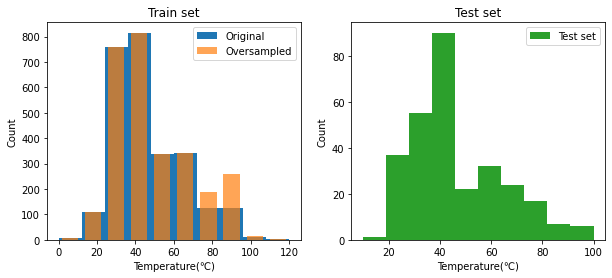

In [21]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(train['topt'],alpha=1,label='Original');
axs[0].hist(train_os['topt'],alpha=0.7, histtype='barstacked',rwidth=0.7, label='Oversampled')
axs[0].set_title('Train set')
axs[1].hist(test['topt'], bins=10, color='tab:green', label='Test set');
axs[1].set_title('Test set')
for ax in axs:
    ax.set_xlabel('Temperature(\u2103)')
    ax.set_ylabel('Count')
    ax.legend()

In [22]:
print(len(train_os.index))
print(len(test.index))

2829
291


In [2]:
topt_data = pd.read_csv('../data/Topt/sequence_ogt_topt.csv') 
topt_data.head()

,Unnamed: 0,uniprot_id,ogt,topt,sequence
0,0,P43408,85,70.0,MKNKVVVVTGVPGVGGTTLTQKTIEKLKEEGIEYKMVNFGTVMFEV...
1,1,Q89GR3,26,30.0,MNLAIVEAPADSTPPPADPLDHLADALFHEMGSPGVYGRTALYEDV...
2,2,Q60352,80,37.0,MLTILKLGGSILSDKNVPYSIKWDNLERIAMEIKNALDYYKNQNKE...
3,3,Q97X08,74,80.0,MIMNKLYIIIVPIIVIIVVGVIGGAIYLHHQSPNVKTSSITVTTNE...
4,4,Q7B8C4,30,37.0,MTVKKLYFIPAGRCMLDHSSVNSTLTPGNLLNLPVWCYLLETEEGP...


In [86]:
def get_protinfo(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    response = requests.get(url)
    data = response.json()
    if 'organism' in data.keys():
        organism = data['organism']['scientificName'].split('(')[0].strip()
    else:
        organism = 'unknown'
        
    if 'proteinDescription' in data.keys():
        description = data['proteinDescription']
        if 'recommendedName' in description.keys():
            recName_data = data['proteinDescription']['recommendedName']
            if 'ecNumbers' in recName_data.keys():
                ec = recName_data['ecNumbers'][0]['value'].strip()
            elif 'alternativeNames' in description.keys():
                altName_data = data['proteinDescription']['alternativeNames']
                if 'ecNumbers' in altName_data[0].keys():
                    ec = altName_data[0]['ecNumbers'][0]['value'].strip()
                else:
                    ec='unknown'
            else:
                ec='unknown'
        elif 'submissionNames' in description.keys():
            if 'ecNumbers' in data['proteinDescription']['submissionNames'][0].keys():
                ec = data['proteinDescription']['submissionNames'][0]['ecNumbers'][0]['value'].strip()
            else:
                ec='unknown'
    else:
        ec='unknown'
        
    return {'uniprot_id':uniprot_id, 'ec':ec,'organism':organism}

In [87]:
enz_info = []
for prot_id in list(topt_data['uniprot_id']):
    enz_info.append( get_protinfo(prot_id) )

In [89]:
enz_info = []
for prot_id in list(topt_data['uniprot_id']):
    enz_info.append( get_protinfo(prot_id) )
einfo_pd = pd.DataFrame(enz_info)
einfo_pd.to_csv('../data/Topt/topt_enzinfo.csv',index=None)
einfo_pd.head()

,uniprot_id,ec,organism
0,P43408,2.7.4.3,Methanotorris igneus
1,Q89GR3,6.2.1.n2,Bradyrhizobium diazoefficiens
2,Q60352,2.7.4.26,Methanocaldococcus jannaschii
3,Q97X08,3.2.1.4,Saccharolobus solfataricus
4,Q7B8C4,3.1.1.81,Bacillus thuringiensis subsp. darmstadiensis


## prep input for preoptem

In [7]:
test=pd.read_csv('../data/Topt/test.csv');
records = []
for i in range(len(test.index)):
    records.append( SeqRecord( Seq(list(test['sequence'])[i]), 
                              id =list(test['uniprot_id'])[i], description='' ) )
SeqIO.write(records,'../data/test_preoptem.fasta',"fasta")

291

# pHopt

In [3]:
# train_records = SeqIO.parse( '../data/pHopt/phopt_training.fasta' , "fasta")
# val_records = SeqIO.parse( '../data/pHopt/phopt_validation.fasta' , "fasta")
# test_records = SeqIO.parse( '../data/pHopt/phopt_testing.fasta' , "fasta")
# def records_to_table(records):
#     data = []
#     for record in records:
#         temp = {'uniprot_id':str(record.id).strip(),'sequence':str(record.seq)}
#         temp['pHopt'] = float( record.description.split('|')[3] )
#         temp['EC'] = record.description.split('|')[2].strip()
#         temp['Organism'] = record.description.split('|')[1].strip()
#         data.append(temp)
#     table = pd.DataFrame(data)
#     return table

In [4]:
# train_set = records_to_table(train_records)
# val_set = records_to_table(val_records)
# test_set = records_to_table(test_records)
# train_data = pd.concat([train_set, val_set])

In [36]:
# train_data.to_csv('../data/pHopt/train_pH.csv',index=None)
# test_set.to_csv('../data/pHopt/test_pH.csv',index=None)

# Tm from Meltome atlas

In [13]:
filenames = os.listdir('../../meltome_data/')
Tm_data = pd.DataFrame(columns=['Protein ID', 'simple_fasta', 'Species', 'Tm'])
for file in filenames:
    temp = pd.read_csv('../../meltome_data/'+file)
    temp = temp[['Protein ID', 'simple_fasta', 'Species', 'Tm']]
    Tm_data = pd.concat([Tm_data,temp])
Tm_data = Tm_data.dropna()
Tm_data = Tm_data.rename(columns={'simple_fasta': 'sequence','Tm':'tm'})
Tm_data = Tm_data.reset_index().drop(['index'],axis=1)
# Tm_data.to_csv('../data/Tm/Tm_raw.csv',index=None)

In [38]:
Tm_data = pd.read_csv('../data/Tm/Tm_raw.csv')
train, test = split_table(Tm_data, ratio=0.1)
# train.to_csv('../data/Tm/train_tm.csv',index=None)
# test.to_csv('../data/Tm/test_tm.csv',index=None)

In [41]:
# Oversampling for Tm >= 60 C
train_os = train.copy()
high_tm = (train[train['tm']>=60]).reset_index().drop(['index'],axis=1)
over_high = []
for i in range( len(high_tm.index) ):
    rand_idx = np.random.randint( len( high_tm.index ) - 1,size=1)[0]
    temp_data = dict( high_tm.iloc[rand_idx] )
    over_high.append( temp_data )
over_pd = pd.DataFrame(over_high)
train_os = ( pd.concat([ train_os, over_pd]) ).reset_index().drop(['index'],axis=1)
# train_os.to_csv('../data/Tm/train_os_tm.csv',index=None)

# Vis datasets for Tm and Topt

In [47]:
train_topt = pd.read_csv('../data/Topt/train.csv')
train_os_topt = pd.read_csv('../data/Topt/train_os.csv')
test_topt = pd.read_csv('../data/Topt/test.csv')

train_tm = pd.read_csv('../data/Tm/train_tm.csv')
train_os_tm = pd.read_csv('../data/Tm/train_os_tm.csv')
test_tm = pd.read_csv('../data/Tm/test_tm.csv')

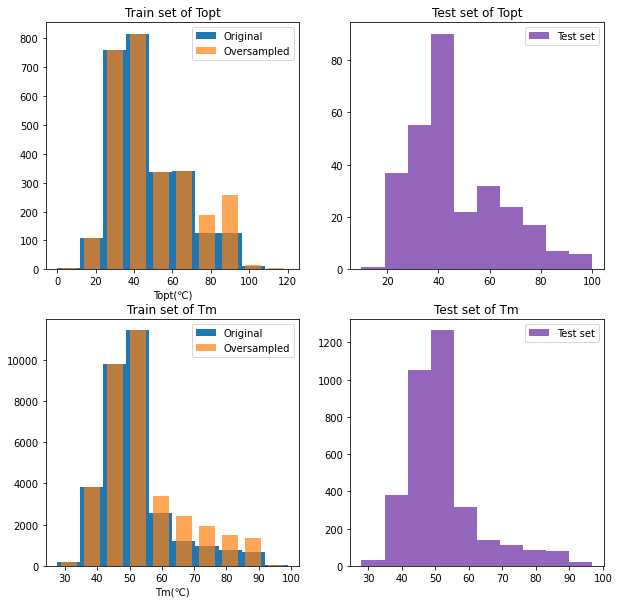

In [51]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0][0].hist(train_topt['topt'],alpha=1,label='Original');
axs[0][0].hist(train_os_topt['topt'],alpha=0.7, histtype='barstacked',rwidth=0.7, label='Oversampled')
axs[0][0].set_title('Train set of Topt')
axs[0][1].hist(test_topt['topt'], bins=10, color='tab:purple', label='Test set');
axs[0][1].set_title('Test set of Topt')
axs[0][0].set_xlabel('Topt(\u2103)')

axs[1][0].hist(train_tm['tm'],alpha=1,label='Original');
axs[1][0].hist(train_os_tm['tm'],alpha=0.7, histtype='barstacked',rwidth=0.7, label='Oversampled')
axs[1][0].set_title('Train set of Tm')
axs[1][1].hist(test_tm['tm'], bins=10, color='tab:purple', label='Test set');
axs[1][1].set_title('Test set of Tm')
axs[1][0].set_xlabel('Tm(\u2103)')

for i in range(2):
    for j in range(2):
        axs[i][j].legend()

# Case study: beta-agarase

In [4]:
# betaA = pd.read_csv('../data/casestudy/beta_agarase.csv')
# seqs = []
# for pid in list(betaA['uniprot_id']):
#     seq = get_seq(pid)
#     seqs.append(seq)
# betaA['sequence'] = seqs
# betaA.to_csv('../data/casestudy/beta_agarase.csv',index=None)

# Default hyperparameters

In [3]:
# default_dict = { 'dim':320,'window':5,'dropout':0.1,'n_head':4,'n_RD':3 }
# dump_pickle( default_dict, '../data/performances/default.pkl')

In [2]:
# win_sizes = [3,5,7]; dropouts = [0.1,0.2,0.5]; ind = 1;
# for win_size in win_sizes:
#     for dp in dropouts:
#         temp_dict = { 'window': win_size,'dropout':dp,'n_head':4,'n_RD': 3 }
#         dump_pickle( temp_dict, '../data/hyparams/params_'+str(ind)+'.pkl')
#         ind +=1